## Data Collection and Feature Engineering steps

In [1]:
from IPython.display import clear_output
!pip install transformers[torch]
!pip install nlpaug
clear_output()

In [2]:
import numpy as np
import pandas as pd
import torch
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from transformers import BertTokenizer
# Ensure you have the necessary resources downloaded
nltk.download('punkt')
nltk.download('stopwords')

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def map_emotions(data):
    emotions_dict = {
        0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
        5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
        10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
        15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
        20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
        25: "sadness", 26: "surprise", 27: "neutral"
    }
    emotion_mapping = {
        "admiration": "positive_intent", "amusement": "positive_intent", "anger": "negative_intent", "annoyance": "negative_intent",
        "approval": "positive_intent", "caring": "positive_intent", "confusion": "inquiry", "curiosity": "inquiry",
        "desire": "positive_intent", "disappointment": "negative_intent", "disapproval": "negative_intent", "disgust": "negative_intent",
        "embarrassment": "negative_intent", "excitement": "positive_intent", "fear": "urgency", "gratitude": "positive_intent",
        "grief": "negative_intent", "joy": "positive_intent", "love": "positive_intent", "nervousness": "urgency",
        "optimism": "positive_intent", "pride": "positive_intent", "realization": "inquiry", "relief": "positive_intent",
        "remorse": "negative_intent", "sadness": "negative_intent", "surprise": "positive_intent", "neutral": "neutral"
    }
    category_to_int_mapping = {
        "neutral": 0, "negative_intent": 1, "positive_intent": 2, "inquiry": 3, "urgency": 4
    }
    def map_emotion(emotion_id):
        original_emotion = emotions_dict.get(int(emotion_id), 'other')
        category = emotion_mapping.get(original_emotion, 'other')
        return category_to_int_mapping.get(category, -1)  # Use -1 for any unmapped categories
    data['emotion'] = data['emotion'].apply(map_emotion)
    return data

def sample_data(data, fraction=1.0):
    sampled = data.groupby('emotion').sample(frac=fraction, replace=False)
    return sampled.reset_index(drop=True)

def augment_data(train_data):
    # Initialize the augmenter
    aug = naw.SynonymAug(aug_src='wordnet')

    def augment_comments(comments, num_augments):
        augmented_comments = []
        for comment in comments:
            comment_str = ' '.join(comment) if isinstance(comment, list) else str(comment)
            for _ in range(num_augments):
                augmented = aug.augment(comment_str)
                # Check if augmented is a list and take the first element if so
                if isinstance(augmented, list):
                    augmented_comments.append(str(augmented[0]))
                else:
                    augmented_comments.append(str(augmented))
        return augmented_comments

    def augment_class(data, class_label, target_count):
        class_data = data[data['emotion'] == class_label]
        current_count = len(class_data)
        augment_count = target_count - current_count
        if augment_count > 0:
            num_augments = augment_count // current_count + 1
            augmented_comments = augment_comments(class_data['comment'].tolist(), num_augments)[:augment_count]
            augmented_emotions = [class_label] * len(augmented_comments)
            return pd.DataFrame({'comment': augmented_comments, 'emotion': augmented_emotions})
        return pd.DataFrame()

    # Calculate the class distribution
    class_counts = train_data['emotion'].value_counts()
    max_count = class_counts.max()

    # Augment minority classes
    augmented_data = []
    for class_label, count in class_counts.items():
        if count < max_count:
            augmented_data.append(augment_class(train_data, class_label, max_count))

    if augmented_data:
        augmented_data = pd.concat(augmented_data).reset_index(drop=True)
    else:
        augmented_data = pd.DataFrame(columns=['comment', 'emotion'])

    # Combine with the original data
    augmented_train_data = pd.concat([train_data, augmented_data]).reset_index(drop=True)

    # Ensure all comments in the final dataframe are strings
    augmented_train_data['comment'] = augmented_train_data['comment'].apply(str)

    return augmented_train_data

def remove_stopwords(data):
    stop_words = set(stopwords.words('english'))
    data['comment'] = data['comment'].apply(lambda comment: ' '.join([word for word in word_tokenize(comment) if word.lower() not in stop_words]))
    return data

def tokenize_data(comments):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

def transform_data(data_url, augmentation=True):
    data = load_data(data_url)
    data = preprocess_data(data)
    data = map_emotions(data)
    data = sample_data(data)
    if augmentation:
        data = augment_data(data)
    # data = remove_stopwords(data)
    tokenized_comments = tokenize_data(data['comment'].to_list())
    return tokenized_comments, torch.tensor(data['emotion'].values)

# URLs for train and validation data
train_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train and validation data
train_tokenized_comments, y_train = transform_data(train_data_url)
validation_tokenized_comments, y_validation = transform_data(validation_data_url, augmentation=False)

# Prepare data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
X_validation = validation_tokenized_comments['input_ids']
attention_masks_validation = validation_tokenized_comments['attention_mask']

print()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique:", np.unique(y_train))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



X_train shape: torch.Size([68200, 316])
y_train shape: torch.Size([68200])
y_train unique: [0 1 2 3 4]


# 1. Model Building

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

### Initialization

In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def print_device_info(device):
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    elif device.type == "mps":
        torch.mps.empty_cache()
        print(f"MPS memory allocated: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
    elif device.type == "cpu":
        print("No GPU available. Using CPU.")

device = get_device()
print_device_info(device)

Using device: cuda
CUDA Device: NVIDIA A100-SXM4-40GB
CUDA memory allocated: 0.00 GB


### Define the model

In [4]:
from transformers import BertForSequenceClassification
# Load the BERT model
# we will use the bert-base-uncased model
# this model will classify the comments into 10 emotions

# Modify the BERT model to include dropout
class BertForSequenceClassificationWithDropout(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return torch.nn.utils.rnn.PackedSequence(logits=logits, loss=loss, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Load the modified BERT model for sequence classification with dropout
model = BertForSequenceClassificationWithDropout.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device);  # Move the model to the GPU

Some weights of BertForSequenceClassificationWithDropout were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the emotion dataset

In [5]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback


# Create a Dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare datasets for cross-validation
datasets = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    attention_masks_train_fold, attention_masks_val_fold = attention_masks_train[train_index], attention_masks_train[val_index]

    train_dataset_fold = EmotionDataset(X_train_fold, attention_masks_train_fold, y_train_fold)
    val_dataset_fold = EmotionDataset(X_val_fold, attention_masks_val_fold, y_val_fold)

    datasets.append((train_dataset_fold, val_dataset_fold))

# Define training arguments with advanced scheduler
training_args = TrainingArguments(
    output_dir='./results',  # Directory to save the model checkpoints
    num_train_epochs=20,  # Increased number of epochs
    per_device_train_batch_size=16,  # Smaller batch size
    per_device_eval_batch_size=32,  # Batch size for evaluation
    warmup_steps=50,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=20,  # Log every X updates steps
    evaluation_strategy="steps",  # Evaluate the model every X steps
    save_strategy="steps",  # Save the model checkpoint every X steps
    save_steps=20,  # Steps interval for saving model checkpoint
    eval_steps=20,  # Steps interval for evaluation
    gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    fp16=True,  # Use 16-bit (mixed) precision training
    learning_rate=3e-5,  # The initial learning rate for AdamW optimizer
    load_best_model_at_end=True,  # Load the best model when finished training
    lr_scheduler_type="cosine_with_restarts",  # Cosine annealing scheduler with restarts
    metric_for_best_model="eval_loss",  # Use loss to identify the best model
    save_total_limit=2,  # Limit the total amount of checkpoints. Deletes the older checkpoints.
    greater_is_better=False,  # Set to True if the metric to optimize is greater (e.g. Accuracy, F1). False for metrics which are lower (e.g. loss)
)

# Train model with cross-validation
for train_dataset_fold, val_dataset_fold in datasets:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping with patience of 3
    )
    trainer.train()

# Final evaluation on the validation set
validation_dataset = EmotionDataset(X_validation, attention_masks_validation, y_validation)
trainer.evaluate(eval_dataset=validation_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
20,1.644800,1.603199
40,1.601200,1.560420
60,1.529300,1.416341
80,1.378200,1.222692
100,1.215400,1.081357
120,1.062700,0.968171
140,0.998000,1.039761
160,1.036700,0.869575
180,0.929800,0.832552
200,0.886700,0.786447


Step,Training Loss,Validation Loss
20,0.801700,0.776072
40,0.847700,0.768240
60,0.793100,0.772538
80,0.784800,0.734534
100,0.786800,0.708990
120,0.775700,0.707989
140,0.741200,0.706024
160,0.731300,0.703298
180,0.758900,0.680496
200,0.746600,0.701887


Step,Training Loss,Validation Loss
20,0.588000,0.574675
40,0.626600,0.567100
60,0.603400,0.602530
80,0.649500,0.579889
100,0.633700,0.572344


Step,Training Loss,Validation Loss
20,0.588200,0.572935
40,0.603800,0.564643
60,0.583500,0.588697
80,0.598800,0.567021
100,0.591900,0.558923
120,0.559900,0.587871
140,0.586400,0.592099
160,0.604400,0.555448
180,0.616200,0.568687
200,0.655300,0.587683


Step,Training Loss,Validation Loss
20,0.562700,0.533228
40,0.638500,0.537779
60,0.551500,0.533911
80,0.578700,0.533170
100,0.578400,0.529143
120,0.615600,0.540064
140,0.527000,0.543625
160,0.626400,0.565875


{'eval_loss': 0.8032140731811523,
 'eval_runtime': 2.1975,
 'eval_samples_per_second': 2069.186,
 'eval_steps_per_second': 65.074,
 'epoch': 0.093841642228739}

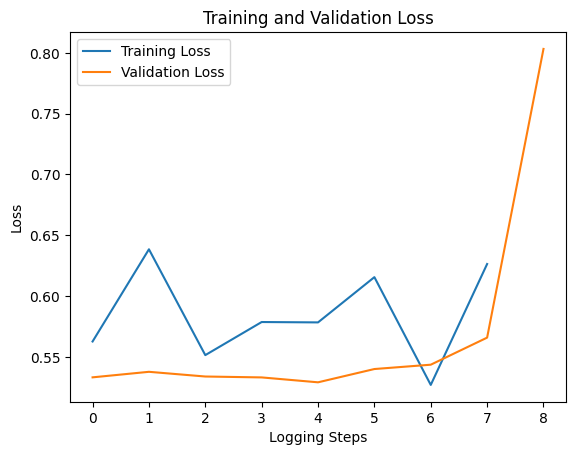

In [6]:
import matplotlib.pyplot as plt

# Extract loss values from the logs
train_losses = []
eval_losses = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Save Model (only from google drive)

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

project_name = "NMA-GoEmotions-Project"
model_save_path = f'/content/drive/MyDrive/@NMA_Projects/{project_name}/{project_name}/model'

source_path = './results/'

# Create the destination directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save only the classification layer weights
classifier_weights = model.classifier.state_dict()
torch.save(classifier_weights, os.path.join(model_save_path, 'classifier_weights_bert_newmapping_improved.pt'))

print(f"Model copied to Google Drive at: {model_save_path}")

Model copied to Google Drive at: /content/drive/MyDrive/@NMA_Projects/NMA-GoEmotions-Project/NMA-GoEmotions-Project/model
